In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import string

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from tqdm._tqdm_notebook import tqdm_notebook

tqdm_notebook.pandas()

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('../data/final_data_priority.csv')

In [3]:
df.isna().sum() / len(df) * 100

short_descriptions    1.620004
priority              1.608561
dtype: float64

In [4]:
df.dropna(inplace=True)

In [5]:
df = df[~df.duplicated()]

In [6]:
df.tail()

,short_descriptions,priority
166044,Data files per our call,4 - Low
166045,Approver Matrix,4 - Low
166046,a new Product Hierarchy Level 5 and 6: Vegeta...,4 - Low
166047,[SAP] Create SAP account in PROD for Charala...,4 - Low
166048,APO Daily and Monthly Chains to be triggere...,4 - Low


In [7]:
cnt_asgn_grps = df['priority'].value_counts()

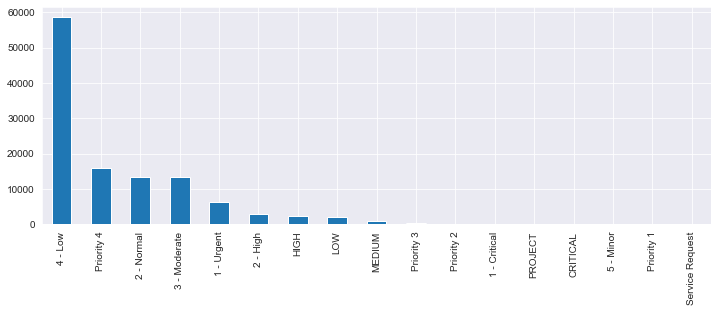

In [8]:
cnt_asgn_grps.plot(kind='bar', figsize=(12, 4))
plt.show()

In [9]:
np.unique(df['priority'])

array(['1 - Critical', '1 - Urgent', '2 - High', '2 - Normal',
       '3 - Moderate', '4 - Low', '5 - Minor', 'CRITICAL', 'HIGH', 'LOW',
       'MEDIUM', 'PROJECT', 'Priority 1', 'Priority 2', 'Priority 3',
       'Priority 4', 'Service Request'], dtype=object)

In [10]:
new_df = df.copy()

In [11]:
replacements = {
    '4 - Low': 'LOW',
    '5 - Minor': 'LOW',
    '3 - Moderate': 'MEDIUM',
    '2 - Normal': 'MEDIUM',
    'Priority 4': 'MEDIUM',
    'Priority 3': 'HIGH',
    'Priority 1': 'CRITICAL',
    'Priority 2': 'CRITICAL',
    '1 - Critical': 'CRITICAL',
    '1 - Urgent': 'CRITICAL',
    '2 - High': 'CRITICAL',
    'PROJECT': np.nan,
    'Service Request': np.nan
}

In [12]:
new_df = new_df.replace(
    {
        'priority': replacements
    }
)

In [13]:
new_df.isna().sum() / len(new_df) * 100

short_descriptions    0.000000
priority              0.071023
dtype: float64

In [14]:
new_df.dropna(inplace=True)

In [15]:
cnt_asgn_grps = new_df['priority'].value_counts()

In [16]:
cnt_asgn_grps

LOW         60784
MEDIUM      43534
CRITICAL     9741
HIGH         2722
Name: priority, dtype: int64

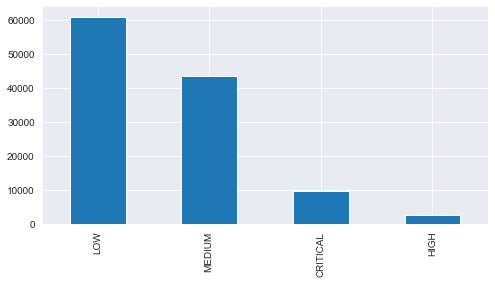

In [17]:
cnt_asgn_grps.plot(kind='bar', figsize=(8, 4))

plt.show()

In [18]:
new_df['short_descriptions'] = new_df['short_descriptions'][
    new_df['short_descriptions'].progress_apply(lambda x: len(x.split()) > 1)]

new_df.dropna(inplace=True)

In [19]:
X, y = new_df['short_descriptions'], new_df['priority']

In [20]:
def clean_text(text: str):
    text = text.lower()
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'  +', ' ', text)
    return text

In [21]:
X = X.progress_apply(lambda x: clean_text(x))

In [22]:
X[-5:]

166044                              data files per our call
166045                                     approver matrix 
166046     a new product hierarchy level and vegetable oil 
166047     sap create sap account in prod for charalampo...
166048     apo daily and monthly chains to be triggered ...
Name: short_descriptions, dtype: object

In [23]:
vectorizer = TfidfVectorizer() #HashingVectorizer(n_features=30000)
encoder = LabelEncoder()

over_sampler = SMOTE(random_state=0, n_jobs=-1)

In [24]:
X_vec = vectorizer.fit_transform(X)
y_enc = encoder.fit_transform(y)

In [25]:
X, y = over_sampler.fit_resample(X_vec, y_enc)

In [26]:
X = vectorizer.inverse_transform(X)
y = encoder.inverse_transform(y)

In [27]:
len(X), len(y)

(242264, 242264)

In [28]:
res_df = pd.DataFrame(
    {
        'short_descriptions': X,
        'priority': y
    }
)

In [29]:
res_df.tail()

,short_descriptions,priority
242259,"[to, sap, in, and, bi, bpc, different, price, le]",MEDIUM
242260,"[in, share, requests, category, service]",MEDIUM
242261,"[failed, online, package]",MEDIUM
242262,"[machine, is, offline, hvd]",MEDIUM
242263,"[to, it, in, and, ad, be, accounts, idm, activ...",MEDIUM


In [30]:
res_df['priority'].value_counts()

MEDIUM      60566
HIGH        60566
LOW         60566
CRITICAL    60566
Name: priority, dtype: int64

In [31]:
res_df['short_descriptions'] = res_df['short_descriptions'].apply(lambda x:' '.join(x))

In [32]:
res_df.tail()

,short_descriptions,priority
242259,to sap in and bi bpc different price le,MEDIUM
242260,in share requests category service,MEDIUM
242261,failed online package,MEDIUM
242262,machine is offline hvd,MEDIUM
242263,to it in and ad be accounts idm active re need...,MEDIUM


In [33]:
res_df.to_csv('../data/balanced_data_deduplicated.csv', index=False)

In [34]:
joblib.dump(value=vectorizer, filename='../models/vectorizer_dd.pkl', compress=3)
joblib.dump(value=encoder, filename='../models/encoder_dd.pkl', compress=3)

['../models/encoder_dd.pkl']